In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const

In [2]:
from agnprocesses import cosmology, synchro, ic, ebl
import agnprocesses.spectra as spec

# Defining geometry, distance and magnetic field

In [3]:
z = 0.3365  # source redshift
doppler = 30.0  # Doppler blob factor
r_b = 5.598e+16 * u.cm  # blob radius

d_l = cosmology.luminosity_distance(z).to(u.cm)
print(f'luminositu distance is {d_l:.6e}')

b = 50.0 * u.mG  # magnetic field induction

norm_e = 7.959e+39 * u.eV**(-1)

luminositu distance is 5.643309e+27 cm


# Synchrotron spectrum calculation

In [4]:
norm_e = 7.959e+39 * u.eV**(-1)
gamma1 = 1.9
gamma2 = 4.5
e_br = 9.0e+09 * u.eV
e_min_e = 5.0e+06 * u.eV
e_max_e = 1.0e+12 * u.eV

e_e = np.logspace(
    np.log10(e_min_e.to(u.eV).value),
    np.log10(e_max_e.to(u.eV).value),
    100
) * u.eV

nu = np.logspace(7, 18.0, 100) * u.Hz
synchro_spec = synchro.derishev_synchro_spec(nu, b,
                                             norm=norm_e,
                                             spec_law='broken_power_law',
                                             gamma1=gamma1,
                                             gamma2=gamma2,
                                             en_break=e_br,
                                             en_min=e_min_e,
                                             en_max=e_max_e)
synchro_epsilon = (const.h * nu).to(u.eV)
synchro_density = (synchro_spec / (4.0 / 3.0 * np.pi * r_b**2 * const.c.to(
    u.cm / u.s)
)).to(u.eV**(-1) * u.cm**(-3))
field = spec.create_2column_table(synchro_epsilon,
                                  synchro_density)
synchro_e = synchro_epsilon / (1.0 + z) * doppler
synchro_sed = synchro_epsilon**2 * synchro_spec
synchro_sed = synchro_sed * doppler**4 / (4.0 * np.pi * d_l**2)

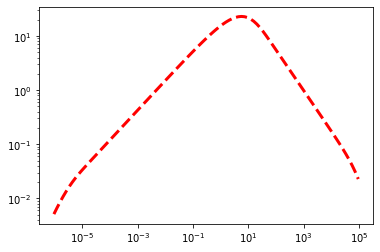

In [5]:
def plot_synchro(ax):
    ax.loglog(
        synchro_e, synchro_sed,
        marker=None, linestyle='--', linewidth=3, color='r',
        label='synchrotron (without SSA)',
    )

fig, ax = plt.subplots()
plot_synchro(ax)

# Inverse Compton effect

In [6]:
ic_e = np.logspace(0, 11.5, 100) * u.eV
ic_spec = ic.inverse_compton_spec(ic_e,
                                  field,
                                  norm=norm_e,
                                  spec_law='broken_power_law',
                                  gamma1=gamma1,
                                  gamma2=gamma2,
                                  en_break=e_br,
                                  en_min=e_min_e,
                                  en_max=e_max_e,
                                  background_photon_energy_unit=synchro_epsilon.unit,
                                  background_photon_density_unit=synchro_density.unit)
ic_sed = ic_e**2 * ic_spec
ic_e *= doppler / (1.0 + z)
ic_sed *= doppler**4 / (4.0 * np.pi * d_l**2)

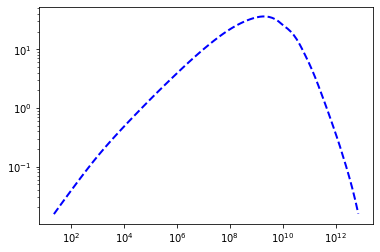

In [7]:
def plot_ic(ax):
    ax.loglog(
        ic_e, ic_sed,
        marker=None, linewidth=2, linestyle='--', color='b', label='SSC',
    )

fig, ax = plt.subplots()
plot_ic(ax)

# IC and synchro SED sum

In [8]:
summ_e, summ_sed = spec.summ_spectra(synchro_e, synchro_sed, ic_e, ic_sed, nbin=100)
summ_filter = (summ_e < 2.0 * u.TeV)  # filter to plot only up to 2 TeV
summ_e = summ_e[summ_filter]
summ_sed = summ_sed[summ_filter]

In [9]:
summ_sed_with_absorption = summ_sed * np.exp(-ebl.tau_gilmore(summ_e, z))

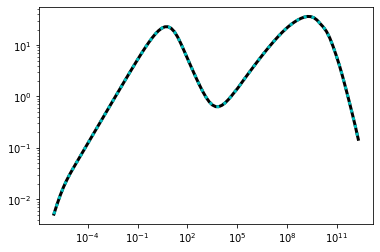

In [10]:
def plot_summ(ax):
    ax.loglog(
        summ_e, summ_sed,
        marker=None, linestyle=':', linewidth=3, color='c',
        zorder=100,
        label='summ w/o EBL absorption'
    )
    ax.loglog(
        summ_e, summ_sed,
        marker=None, linestyle='-', linewidth=3, color='k',
        label='summ w/ EBL absorption'
    )

fig, ax = plt.subplots()
plot_summ(ax)

# Experimental data from `Aartsen M et al. 2018. Science. 361(6398)`

[Source](https://science.sciencemag.org/content/361/6398/eaat1378)

In [11]:
from agnprocesses.data_files import SCIENCE_2018_EXAMPLE_DATA
data = np.loadtxt(SCIENCE_2018_EXAMPLE_DATA)

data_en = data[:, 0]
data_sed = data[:, 1]
data_low = data[:, 3]
data_up = data[:, 2]
yerr = [data_low, data_up]

def plot_experiment(ax):
    plt.errorbar(
        data_en, data_sed,
        yerr=yerr, xerr=None, fmt='o', linewidth=0, elinewidth=2,
        capsize=1, barsabove=False, markersize=5,
        errorevery=1, capthick=1, color='r', zorder=100.0
    )

# Final result

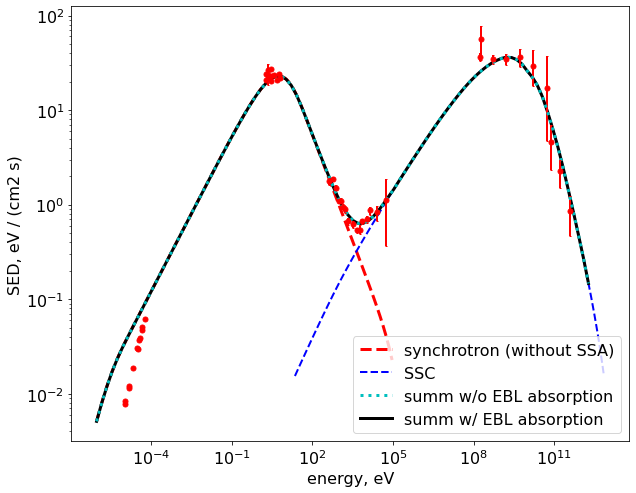

In [19]:
with plt.rc_context({'font.size': 16}):
    fig, ax = plt.subplots(figsize=(10, 8))

    plot_synchro(ax)
    plot_ic(ax)
    plot_summ(ax)
    plot_experiment(ax)

    ax.set_xlabel('energy, ' + str(ic_e.unit))
    ax.set_ylabel('SED, ' + str(ic_sed.unit))
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.legend()
    plt.show()